# LTSF-Linear

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Linear Model

In the following cell, we create our Linear module, necessary for performing our Long-Term Time Series Forecasting project. The module accepts positional arguments for the sequence length, used to determine the number of entries in the past utilized for forecasting the future energy usage of appliances, as well as the prediction length, which determines the forecasting horizon. Additionally, the keyword argument allows us to specify the number of input channels in the dataset that allows us to base the prediction on the entries that apply to certain features (i.e. appliances) in the dataset. The number of channels specified ultimately controls the number of parameters provided by the model in the different Linear layers used for handling each different form of input separately.

In [2]:
class Linear(nn.Module):
    def __init__(self, sequence_length, prediction_length, channels=2):
        super(Linear, self).__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.linears = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])

    def forward(self, x):
        out = torch.tensor([], dtype=x.dtype, device=x.device)
        for channel, linear in enumerate(self.linears):
            pred = linear(x[:, :, channel]).unsqueeze(-1)
            out = torch.cat([out, pred], dim=-1)
        return out

## Dataset

In the following cell, we create our ApplianceEnergyUsageDataset (https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction) class for forecasting the energy usage of lights and appliances in our Linear module we defined above. In addition, we also include the utility functions, get_train_dataset and get_test_dataset, used for obtaining the separate training and testing datasets for use by our Linear model. We split the dataset by reserving the first 80% of the samples for training our model, and use the remaining 20% for the model testing. As per discussed in the literature, normalization is applied for scaling the test data by the mean and variance of the training data to help improve model performance.

In [3]:
class ApplianceEnergyUsageDataset(Dataset):
    def __init__(self, energy_data, sequence_length, prediction_length):
        super().__init__()
        self.energy_data = energy_data
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length        

    def __getitem__(self, index):
        sequence_begin = index
        sequence_end = sequence_begin + self.sequence_length
        x = self.energy_data[sequence_begin:sequence_end]
        prediction_begin = sequence_end
        prediction_end = prediction_begin + self.prediction_length
        y = self.energy_data[prediction_begin:prediction_end]
        return x, y

    def __len__(self):
        return len(self.energy_data) - self.sequence_length - self.prediction_length + 1


energy_data_file = '../../datasets/appliances_energy_prediction/energydata_complete.csv'
energy_data = pd.read_csv(energy_data_file, usecols=[1, 2])
training_samples = int(len(energy_data) * 0.8)
scaler = StandardScaler()
train_data = scaler.fit_transform(energy_data.iloc[:training_samples].values)

def get_train_dataset(sequence_length, prediction_length):
    dataset = ApplianceEnergyUsageDataset(train_data, 
                                          sequence_length, 
                                          prediction_length)
    return dataset

def get_test_dataset(sequence_length, prediction_length):
    test_data = scaler.transform(energy_data.iloc[
        training_samples - sequence_length:].values)
    dataset = ApplianceEnergyUsageDataset(test_data,
                                          sequence_length,
                                          prediction_length)
    return dataset

## Model Training/Evaluation

In the following cells, we obtain the statistics related to model loss (in terms of MSE between target and predicted values) on the test dataset for varying values of the sequence length and prediction horizon. We set the look-back window size as {24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672, 720} (corresponding to 4, 8, 12, 16, 20, 24, 28, 32, 56, 84, 112 or 120 hours) and forecasting steps as {24, 720} (corresponding to 4 or 120 hours). We define the train and test functions below for training and testing our model, respectively:

In [4]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = [_.to(torch.float32).to(device) for _ in (X, y,)]
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(dataloader, model, criterion):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = [_.to(torch.float32).to(device) for _ in (X, y,)]
            pred = model(X)
            test_loss += criterion(pred, y).item()
    test_loss /= num_batches
    return test_loss

Next, we iterate through the possible combinations of forecasting steps and look-back window sizes to find the optimal value that minimizes the model's loss on the test set. Generally speaking, larger look-back window sizes should correspond to more accurate forecasting predictions, but we also want to verify the results empirically to determine which values work best for our dataset. We store the values for the model loss on the test dataset, as well as the parameters for the sequence length and prediction length used, for visualizing the results in seaborn.FacetGrid below.

In [5]:
BATCH_SIZE = 64
FORECASTING_STEPS = [24, 720]
LOOKBACK_WINDOW_SIZES = [24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672, 720]

def get_loss_data(model_class):
    loss_data = {'Prediction Length': [], 'Sequence Length': [], 'Avg Loss': [], 'Model': []}
    for pred_length in FORECASTING_STEPS:
        for seq_length in LOOKBACK_WINDOW_SIZES:
            train_dataset = get_train_dataset(seq_length, pred_length)
            test_dataset = get_test_dataset(seq_length, pred_length)
            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
            test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
            model = model_class(seq_length, pred_length).to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            epochs = 10
            for epoch in range(epochs):
                train(train_dataloader, model, criterion, optimizer)
            test_loss = test(test_dataloader, model, criterion)
            loss_data['Avg Loss'].append(test_loss)
            loss_data['Prediction Length'].append(pred_length)
            loss_data['Sequence Length'].append(seq_length)
            loss_data['Model'].append(model_class.__name__)
    return loss_data

## Visualize Results

In the following cell output, we visualize model loss for each of the values used for sequence length and prediction horizon used to train the model and obtain the results. The model loss is determined in MSE between target and predicted values for each of the appliances in the test dataset.

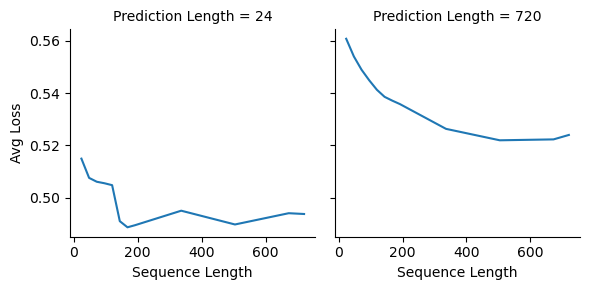

In [6]:
loss_data = get_loss_data(Linear)
df_losses = pd.DataFrame(loss_data)
g = sns.FacetGrid(df_losses, col='Prediction Length')
g.map(sns.lineplot, 'Sequence Length', 'Avg Loss')

Based on the outputs from the previous cell, we can confirm that higher values for the sequence length corresponds to better performing models and improve predictions of energy usage for each of the appliance for the respective prediction horizons. The effect of increasing the look-back window size seems to be somewhat less pronounced for the shorter prediction horizon of 24 (4 hours). Incorporating more historical data for the energy usage of the appliances seems to be more beneficial for the much larger prediction horizon of 720 (120 hours). This seems to match well with the reasoning of appliance energy usage tending to exhibit distinct patterns or characteristics that can only be captured by considering the values spanning a much longer duration of time, such as the number of days in a week.

### NLinear Model

Since we normalize test data by the mean and variance of the training data, there is a potential for the mean value of the test data to not be 0. Large errors could occur if the model makes a prediction that is out of distribution of the true value. In the following experiment, we introduce a new model, NLinear, that shifts the model prediction towards the distribution of true value by subtracting and adding the last value of the input sequence.

In [7]:
class NLinear(nn.Module):
    def __init__(self, sequence_length, prediction_length, channels=2):
        super(NLinear, self).__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.linears = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])

    def forward(self, x):
        out = torch.tensor([], dtype=x.dtype, device=x.device)
        seq_last = x[:, -1:, :].detach()
        x = x - seq_last
        for channel, linear in enumerate(self.linears):
            pred = linear(x[:, :, channel]).unsqueeze(-1)
            out = torch.cat([out, pred], dim=-1)
        out = out + seq_last
        return out

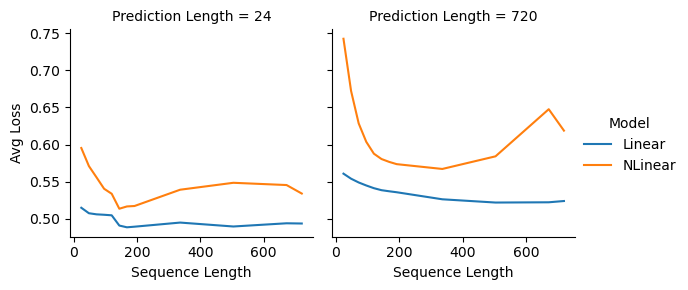

In [8]:
for key, values in get_loss_data(NLinear).items():
    loss_data[key] += values
df_losses = pd.DataFrame(loss_data)
g = sns.FacetGrid(df_losses, col='Prediction Length', hue='Model')
g.map(sns.lineplot, 'Sequence Length', 'Avg Loss')
g.add_legend()

Based on the result above, it is probably safe to assume that there does not exist a substantial distribution shift between the training and testing data. Therefore, the adjustments applied in subtracting and adding the last value of the input sequence presumably were not necessary, and have lead to poorer performing model. This allows us to infer that potential the energy appliance usage in the dataset takes on values that are relatively more stable over time, and do not vary exceedingly between the training and testing datasets.

### DLinear Model

For the DLinear model, we first decompose the raw input data into a trend component by a moving average kernel and a remainder (seasonal) component, then apply two linear layers to each component and sum the feature vectors together to obtain a final prediction. We believe that by explicitly handling trend in DLinear model, that we will be able to improve upon our vanilla Linear model by explicitly capturing patterns related to long-term trends or seasonality of the appliance energy usage.

In [9]:
class MovingAverage(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MovingAverage, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = MovingAverage(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    def __init__(self, sequence_length, prediction_length, channels=2):
        super(DLinear, self).__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.decomposition = SeriesDecomposition(25)
        self.seasonal = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])
        self.trend = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])        

    def forward(self, x):
        x_seasonal, x_trend = self.decomposition(x)
        seasonal_out = torch.tensor([], dtype=x_seasonal.dtype, device=x_seasonal.device)
        for channel, linear in enumerate(self.seasonal):
            pred = linear(x_seasonal[:, :, channel]).unsqueeze(-1)
            seasonal_out = torch.cat([seasonal_out, pred], dim=-1)
        trend_out = torch.tensor([], dtype=x_trend.dtype, device=x_trend.device)
        for channel, linear in enumerate(self.trend):
            pred = linear(x_trend[:, :, channel]).unsqueeze(-1)
            trend_out = torch.cat([trend_out, pred], dim=-1)
        out = seasonal_out + trend_out
        return out

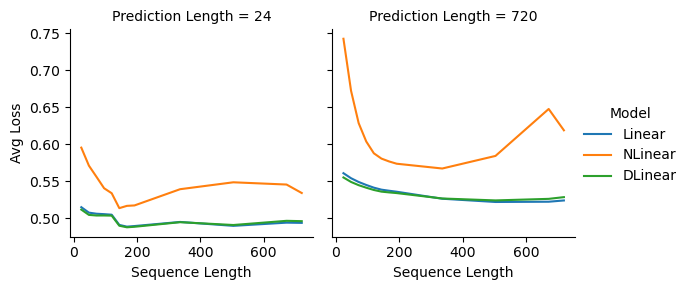

In [10]:
for key, values in get_loss_data(DLinear).items():
    loss_data[key] += values
df_losses = pd.DataFrame(loss_data)
g = sns.FacetGrid(df_losses, col='Prediction Length', hue='Model')
g.map(sns.lineplot, 'Sequence Length', 'Avg Loss')
g.add_legend()

It appears our DLinear model performs on par with the vanilla Linear model, suggesting that there may not exist an associated trend or seasonal component as part of the input that may be useful for our prediction. 